In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
from scipy.signal import find_peaks

## Reproduce RNAseq colllection experiment

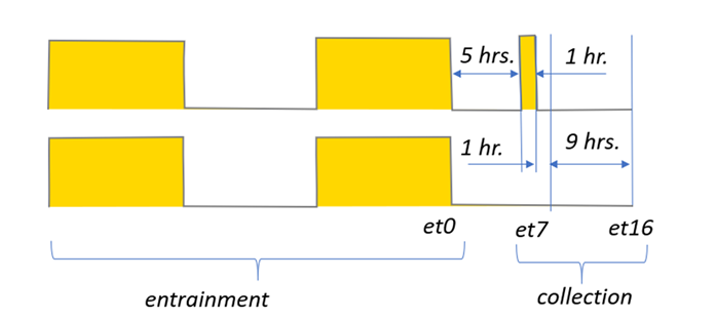

## Generate light stimulus 

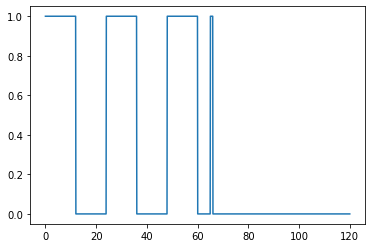

In [9]:
# Set time steps
dt=0.1
T  =120
nsteps =int(T/dt)
t   = np.linspace(0, T, nsteps)
# Select lengh of light and dark periods
light_t = 12.
dark_t  = 12.
total_day = light_t + dark_t 
light_intensity = 1
LD_end=72
pulse_start=65
pulse_end =66
# Create ligth entrainemnt profile
def light_pulse(t, pulse_start, pulse_end, light_intensity):
    light = np.zeros(len(t))
    light[ (t > pulse_start)&(t < pulse_end) ] = light_intensity
    return (light)

# Create ligth entrainemnt profile
def LD(t, light, dark, light_int):
    total_day = light + dark
    light = np.zeros(len(t))
    light[ (t%total_day < light_t)&(t < LD_end) ] = light_int
    return (light)
#plt.plot(t, LD(t, light_t, dark_t, light_intensity)+light_pulse(t, pulse_start, pulse_end, light_intensity))
def light_conditions(t, light, dark, pulse_start, pulse_end,light_int):
    total_day = light + dark
    light = np.zeros(len(t))
    light[ (t%total_day < light_t)&(t < LD_end) |(t > pulse_start)&(t < pulse_end) ] = light_int
    return (light)

plt.plot(t,  light_conditions(t, light_t, dark_t, pulse_start, pulse_end,light_intensity))

# Experimental protocol simulation (Fig 1)

Text(0, 0.5, 'TIM concentration')

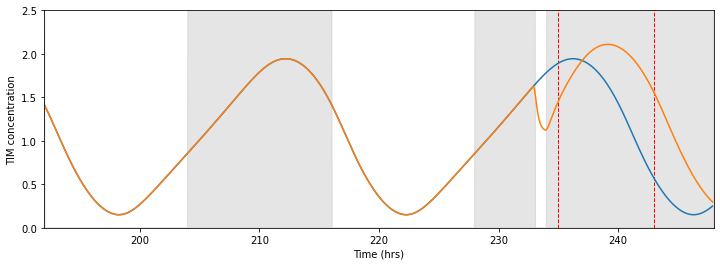

In [10]:
# Set Parameters
Cycc = 1.0
Dbtc = 1.0
C1 = 0.0
C2 = 0.0
C3 = 0.0
S1 = 1.45
S3 = 1.45
S2 = 0.48
S4 = 0.48
S5 = 1.63
S6 = 0.47
r = 4.0
R1 = 1.02
R2 = 1.02
R3 = 0.89
a = 1.0
A1 = 0.45
A2 = 0.45
A3 = 0.8
B1 = 0.0
B2 = 0.0
B3 = 0.6
V1 = 1.45
V2 = 1.45
V3 = 1.63
V4 = 1.63
T1 = 1.73
T2 = 0.72
T3 = 1.63
T4 = 0.52
K1 = 2.0
K2 = 2.0
K3 = 2.0
K4 = 2.0
D1 = 0.94
D3 = 0.94
D2 = 0.44
D4 = 0.44
D5 = 0.44
D6 = 0.29
D7 = 0.54
D8 = 0.6
D9 = 0.6
D10 = 0.3
L1 = 0.3
L3 = 0.3
L2 = 0.2
L4 = 0.2
L5 = 0.2
L6 = 0.2
L7 = 0.13
L8 = 0.2
L9 = 0.2
L10 = 0.2
D0 = 0.012

# Create ligth entrainemnt profile
def light(t, pulse_start, pulse_end, light_intensity):
    light = np.zeros(len(t))
    light[(t%total_day < light_t)&(t < LD_end) |(t > pulse_start)&(t < pulse_end) ] = light_intensity
    return (light)

# function to solve the equation and organize the solution into a data frame
def solution_into_df(soln):
    df = pd.DataFrame(soln, columns = ['Perm', 'Perc', 'Timm', 'Timc', 'PTc', 'PTn', 'Clkm', 'Clkc', 'CCc', 'CCn'])
    df['time'] = df.index*dt
    df.set_index('time', inplace =True)
    return(df)
# Function which make a new column names for solution with light by adding "_l"
def make_columns_for_light(df):
    new_colum_names = []
    for name in df.columns:
        new_name = name+'_l'
        new_colum_names.append(new_name)
    return(new_colum_names)

# Function which adds a light solution as additional columns for data frame with control DD solution
def add_light_solution(df, soln):
    col_ind = 0
    for name in make_columns_for_light(df):
        df[name] = soln[:, col_ind]
        col_ind += 1
    return (df) 

# Define functions for solving ODEs
def df_light(y, t):
    #assign input vector,y to variables of the model
    Perm = y[0]
    Perc = y[1]
    Timm = y[2]
    Timc = y[3]
    PTc  = y[4]
    PTn  = y[5]
    Clkm = y[6]
    Clkc = y[7]
    CCc  = y[8]
    CCn  = y[9]
    
    # light entrainemnt
    if (t%total_day < light_t)&(t < LD_end) |(t > pulse_start)&(t < pulse_end):
        #DD   = D0 + light_intensity
        D5_l = D5 + light_intensity
    else:
        #DD   = D0 
        D5_l = D5
    if (t > pulse_start)&(t < pulse_end):
        #DD   = D0 + pulse_intensity
        D5_l = D5 + pulse_intensity
    else:
        #DD   = D0
        D5_l = D5
        
    dPerm = S1*( CCn/A1     )/(1 + (PTn/R1)**r + CCn/A1      )           -D1*Perm/(L1 +Perm) - D0*Perm
    dTimm = S3*( CCn/A2     )/(1 + (PTn/R2)**r + CCn/A2      )           -D3*Timm/(L3 +Timm) - D0*Timm
    dClkm = S5*( PTn/A3 + B3)/(1 + (CCn/R3)**r + PTn/A3 + B3 )           -D7*Clkm/(L7 +Clkm) - D0*Clkm
    
    dPerc = S2*Perm - V1*Perc*Timc + V2*PTc                              -D2*Perc/(L2 +Perc) - D0*Perc
    dTimc = S4*Timm - V1*Perc*Timc + V2*PTc                              -D4*Timc/(L4 +Timc) - D0*Timc
    dClkc = S6*Clkm - V3*Clkc*Cycc + V4*CCc                              -D8*Clkc/(L8 +Clkc) - D0*Clkc
    
    
    dPTc  = V1*Perc*Timc - V2*PTc -T1*PTc/(K1+PTc) + T2*PTn/(K2+PTn)     -D5_l*PTc/(L5 +PTc ) - D0*PTc
    dPTn  =                        T1*PTc/(K1+PTc) - T2*PTn/(K2+PTn)     -D6  *PTn/(L6 +PTn ) - D0*PTn
    
    dCCc  = V3*Clkc*Cycc - V4*CCc -T3*CCc/(K3+CCc) +T4*CCn/(K4+CCn)      -D9 *CCc/(L9 +CCc ) - D0*CCc
    dCCn  =                        T3*CCc/(K3+CCc) -T4*CCn/(K4+CCn)      -D10*CCn/(L10+CCn ) - D0*CCn
    
    return [dPerm, dPerc, dTimm, dTimc, dPTc, dPTn, dClkm, dClkc, dCCc, dCCn]

# Select lengh of light and dark periods
light_t = 12.
dark_t  = 12.
total_day = light_t + dark_t 

LD_end=230
pulse_start=233
pulse_end =234


# Set time steps
dt=0.1
T  =248
nsteps =int(T/dt)
t   = np.linspace(0, T, nsteps)

# Input initial values for ODEs
y0 = [0.37764557, 0.97873087, 0.37764557, 1.69825736, 1.60486041,
       3.28659401, 1.76455876, 0.29216396, 0.12053413, 0.50265921]
# Solve ODE to get rid of transients and fed the initial condition to the next ODE solver
light_intensity = 10
pulse_intensity = 0.
soln = odeint(df_light, y0, t)
df1 =solution_into_df(soln)
#plt.figure(figsize = (12, 4))
#plt.plot(df_nolight.index,df_nolight.Timc)
pulse_intensity = 10
soln = odeint(df_light, y0, t)
df = add_light_solution(df1, soln)
df['light'] =light(t, pulse_start, pulse_end, light_intensity)
#Adjust the index to plot only after 200 hours
df[['Timc', 'Timc_l']].plot(ylim =(0,2.5), xlim = (192, 248), figsize = [12, 4], legend=False)
plt.vlines(x=243, ymin=0, ymax=2.5, colors='red', ls='--', lw=1)
plt.vlines(x=235, ymin=0, ymax=2.5, colors='red', ls='--', lw=1)
#plt.fill_between(x=t, y1= df.light, color= "orange", alpha= 0.2)
plt.fill_between(x=t, y1= light_intensity-df.light, color= "grey", alpha= 0.2)
plt.xlabel('Time (hrs)')
plt.ylabel('TIM concentration')

# PRC simulation (Fig 2)

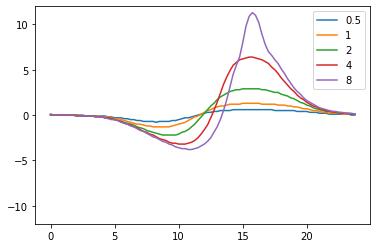

In [11]:
# Define functions for solving ODEs
def df_light(y, t):
    #assign input vector,y to variables of the model
    Perm = y[0]
    Perc = y[1]
    Timm = y[2]
    Timc = y[3]
    PTc  = y[4]
    PTn  = y[5]
    Clkm = y[6]
    Clkc = y[7]
    CCc  = y[8]
    CCn  = y[9]
    
    # light entrainemnt
    if (t > pulse_start)&(t < pulse_end):
        DD   = D0 + light_intensity
        D5_l = D5 + light_intensity
    else:
        #DD   = D0 
        D5_l = D5
    
    dPerm = S1*( CCn/A1     )/(1 + (PTn/R1)**r + CCn/A1      )           -D1*Perm/(L1 +Perm) - D0*Perm
    dTimm = S3*( CCn/A2     )/(1 + (PTn/R2)**r + CCn/A2      )           -D3*Timm/(L3 +Timm) - D0*Timm
    dClkm = S5*( PTn/A3 + B3)/(1 + (CCn/R3)**r + PTn/A3 + B3 )           -D7*Clkm/(L7 +Clkm) - D0*Clkm
    
    dPerc = S2*Perm - V1*Perc*Timc + V2*PTc                              -D2*Perc/(L2 +Perc) - D0*Perc
    dTimc = S4*Timm - V1*Perc*Timc + V2*PTc                              -D4*Timc/(L4 +Timc) - D0*Timc
    dClkc = S6*Clkm - V3*Clkc*Cycc + V4*CCc                              -D8*Clkc/(L8 +Clkc) - D0*Clkc
    
    
    dPTc  = V1*Perc*Timc - V2*PTc -T1*PTc/(K1+PTc) + T2*PTn/(K2+PTn)     -D5_l*PTc/(L5 +PTc ) - D0*PTc
    dPTn  =                        T1*PTc/(K1+PTc) - T2*PTn/(K2+PTn)     -D6  *PTn/(L6 +PTn ) - D0*PTn
    
    dCCc  = V3*Clkc*Cycc - V4*CCc -T3*CCc/(K3+CCc) +T4*CCn/(K4+CCn)      -D9 *CCc/(L9 +CCc ) - D0*CCc
    dCCn  =                        T3*CCc/(K3+CCc) -T4*CCn/(K4+CCn)      -D10*CCn/(L10+CCn ) - D0*CCn
    
    return [dPerm, dPerc, dTimm, dTimc, dPTc, dPTn, dClkm, dClkc, dCCc, dCCn]


# Set time steps
dt=0.1
T  =244
nsteps =int(T/dt)
t   = np.linspace(0, T, nsteps)

# Input initial values for ODEs
y0 = [0.37764557, 0.97873087, 0.37764557, 1.69825736, 1.60486041,
           3.28659401, 1.76455876, 0.29216396, 0.12053413, 0.50265921]
# Solve ODE to get rid of transients and fed the initial condition to the next ODE solver
light_intensity = 0.
soln = odeint(df_light, y0, t)
Timc = soln[:,3]
pulse_start_list = np.arange(5, 29, 0.25)
df_prc = pd.DataFrame(data=[], index=pulse_start_list-5)
peaks_DD, _ = find_peaks(df.Timc,  distance=14)
pulse_duration = 1.

light_intensity = 10
light_intensity_list =[0.5, 1, 2, 4, 8]
#plt.plot(figsize = (12, 4))
for light_intensity in light_intensity_list:
    #plt.figure(figsize = (12, 24))
    i_plot =1
    #nplots = len(pulse_start_list)
    phase_resposnce =[]
    for pulse_start in pulse_start_list:
        # Select lengh of light and dark periods
        #pulse_start = 21.
        pulse_end   = pulse_start + pulse_duration
        soln = odeint(df_light, y0, t)
        Timc_l = soln[:,3]
        #light_pulse =light(t, pulse_start, pulse_end, light_intensity)

        #Find peaks in Tim protein    
        peaks_L,  _ = find_peaks(Timc_l, distance=145)
        # Calculate Phase difference in Tim protein concentration
        phi =   t[peaks_DD][-1]-t[peaks_L][-1] 

        i_plot+=1 
        phase_resposnce.append(phi)

    df_prc[str(light_intensity)] =phase_resposnce 
#plt.plot(pulse_start_list-5, phase_resposnce)
df_prc.plot()
plt.ylim(-12,12)
#df_prc
df_prc.to_csv('PRCs_different_light_intensity_D5_light.csv')

([<matplotlib.axis.XTick at 0x11ae7d645b0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

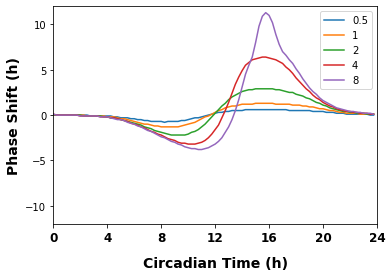

In [28]:
df_prc.plot(figsize = (5.8, 4))
plt.xlabel('Circadian Time (h)', fontsize=14, fontweight='bold', labelpad=12)
plt.ylabel('Phase Shift (h)', fontsize =14, fontweight='bold')
plt.xlim(0,24)
plt.ylim(-12, 12)
plt.xticks(np.arange(0, 25, step=4), fontsize=12, fontweight='bold')